In [1]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
from astropy.cosmology import Planck18 as cosmo
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [3]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if (PC_name_str == 'arc10'or PC_name_str == 'science11' or 
        PC_name_str == 'science10'):
    cores = 84        
#     cores = multi.cpu_count()
    
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

arc10
84


In [4]:
df_sdss_gals = pd.read_csv('../codes_for_SDSS/Data/SAS_FITS/galaxy_DR12v5_CMASSLOWZTOT_all_sky_Comov.csv',
                         index_col = 0)
df_sdss_gals.describe().apply(lambda s: s.apply('{0:.3f}'.format))

/vol/arc10/data1/amirza/Misc/anaconda/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,RA,DEC,Z,r_comov[Mpc/h],X_comov[Mpc/h],Y_comov[Mpc/h],Z_comov[Mpc/h]
count,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000
mean,178.676,23.417,0.452,1188.863,-272.192,-34.199,447.124
std,92.194,18.180,0.157,377.180,899.294,578.618,370.074
min,0.000,-10.997,0.000,0.015,-2286.040,-1975.692,-368.732
25%,135.845,8.361,0.347,953.931,-938.263,-450.408,140.810
50%,181.891,21.477,0.486,1285.598,-563.199,-15.135,387.832
75%,227.366,35.940,0.563,1458.133,539.205,382.666,703.085
max,359.999,68.738,1.137,2518.253,2244.442,1941.727,2033.417


In [5]:
df_sdss_gals['X_comov[kpc/h]'] = df_sdss_gals['X_comov[Mpc/h]']*1e3
df_sdss_gals['Y_comov[kpc/h]'] = df_sdss_gals['Y_comov[Mpc/h]']*1e3
df_sdss_gals['Z_comov[kpc/h]'] = df_sdss_gals['Z_comov[Mpc/h]']*1e3
df_sdss_gals.describe()

,RA,DEC,Z,r_comov[Mpc/h],X_comov[Mpc/h],Y_comov[Mpc/h],Z_comov[Mpc/h],X_comov[kpc/h],Y_comov[kpc/h],Z_comov[kpc/h]
count,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06,1.325735e+06
mean,1.786756e+02,2.341721e+01,4.519571e-01,1.188863e+03,-2.721915e+02,-3.419912e+01,4.471238e+02,-2.721915e+05,-3.419912e+04,4.471238e+05
std,9.219390e+01,1.817975e+01,1.565052e-01,3.771801e+02,8.992936e+02,5.786181e+02,3.700740e+02,8.992936e+05,5.786181e+05,3.700740e+05
min,9.090666e-05,-1.099717e+01,4.893557e-06,1.467050e-02,-2.286040e+03,-1.975692e+03,-3.687325e+02,-2.286040e+06,-1.975692e+06,-3.687325e+05
25%,1.358452e+02,8.360693e+00,3.474941e-01,9.539314e+02,-9.382629e+02,-4.504076e+02,1.408096e+02,-9.382629e+05,-4.504076e+05,1.408096e+05
50%,1.818909e+02,2.147713e+01,4.862676e-01,1.285598e+03,-5.631992e+02,-1.513456e+01,3.878325e+02,-5.631992e+05,-1.513456e+04,3.878325e+05
75%,2.273659e+02,3.593965e+01,5.633048e-01,1.458133e+03,5.392046e+02,3.826665e+02,7.030855e+02,5.392046e+05,3.826665e+05,7.030855e+05
max,3.599986e+02,6.873770e+01,1.136586e+00,2.518253e+03,2.244442e+03,1.941727e+03,2.033417e+03,2.244442e+06,1.941727e+06,2.033417e+06


In [6]:
df_act_clus = pd.read_csv('Data/ACT_DR5_Clusters_Comov.csv', index_col = 0)
df_act_clus.describe()

,RADeg,decDeg,redshift,M500c,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h]
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,151.181353,-11.714340,0.551278,2.649662,1388.196855,215.132575,147.339189,-259.438542
std,117.680597,24.332967,0.260012,1.104196,554.123440,1083.828465,747.609054,604.704775
min,0.020898,-59.987048,0.035200,1.055794,104.654202,-2821.478205,-2384.389583,-2586.737757
25%,39.235119,-34.872174,0.355214,1.983767,973.105415,-740.517454,-354.011021,-667.964036
50%,145.221639,-2.254075,0.519852,2.384140,1361.804643,489.617772,173.962966,-46.151260
75%,232.459288,8.960882,0.710277,2.971812,1765.709159,1026.742279,671.222510,168.331111
max,359.988274,20.486046,1.910000,13.470755,3500.148180,2991.666247,2339.025040,924.612636


In [7]:
df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
df_act_clus.describe()

,RADeg,decDeg,redshift,M500c,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h],x_comov[kpc/h],y_comov[kpc/h],z_comov[kpc/h]
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4.195000e+03,4.195000e+03,4.195000e+03
mean,151.181353,-11.714340,0.551278,2.649662,1388.196855,215.132575,147.339189,-259.438542,2.151326e+05,1.473392e+05,-2.594385e+05
std,117.680597,24.332967,0.260012,1.104196,554.123440,1083.828465,747.609054,604.704775,1.083828e+06,7.476091e+05,6.047048e+05
min,0.020898,-59.987048,0.035200,1.055794,104.654202,-2821.478205,-2384.389583,-2586.737757,-2.821478e+06,-2.384390e+06,-2.586738e+06
25%,39.235119,-34.872174,0.355214,1.983767,973.105415,-740.517454,-354.011021,-667.964036,-7.405175e+05,-3.540110e+05,-6.679640e+05
50%,145.221639,-2.254075,0.519852,2.384140,1361.804643,489.617772,173.962966,-46.151260,4.896178e+05,1.739630e+05,-4.615126e+04
75%,232.459288,8.960882,0.710277,2.971812,1765.709159,1026.742279,671.222510,168.331111,1.026742e+06,6.712225e+05,1.683311e+05
max,359.988274,20.486046,1.910000,13.470755,3500.148180,2991.666247,2339.025040,924.612636,2.991666e+06,2.339025e+06,9.246126e+05


In [8]:
def pre_fac_func(z):
    
    f = cosmo.Om(z)**0.545
    a = 1/(1+z)
    H = cosmo.H(z).value
    
    pre_fac = (f * a * H / (4 * np.pi))           #in km s^−1 Mpc^−1 
    
    return pre_fac

In [9]:
cosmo.Om0

0.30966

In [10]:
cosmo.Om(0.5)

0.6009362572181041

In [12]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

In [13]:
def delta_gal_mean_func(df_act_clus_available, cell_size, radius):
    
    delta_gal_cube = np.zeros(len(df_act_clus_available))
    
    for i, clus in df_act_clus_available.iterrows():
        df_gals_around = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] < (clus['x_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['X_comov[kpc/h]'] > (clus['x_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] < (clus['y_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] > (clus['y_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] < (clus['z_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] > (clus['z_comov[kpc/h]'] - radius))].copy()
        
        
        #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
        df_gals_around['X_comov[kpc/h]'] -= (clus['x_comov[kpc/h]'] - radius)
        df_gals_around['Y_comov[kpc/h]'] -= (clus['y_comov[kpc/h]'] - radius)
        df_gals_around['Z_comov[kpc/h]'] -= (clus['z_comov[kpc/h]'] - radius)

        df_gals_around['X_comov[kpc/h]'] = df_gals_around['X_comov[kpc/h]'] / cell_size
        df_gals_around['Y_comov[kpc/h]'] = df_gals_around['Y_comov[kpc/h]'] / cell_size
        df_gals_around['Z_comov[kpc/h]'] = df_gals_around['Z_comov[kpc/h]'] / cell_size

        #making tuples, converting tuples to cell coordinates
        df_gals_around["cell"] = list(zip(df_gals_around['X_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Y_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Z_comov[kpc/h]'].astype(int)))
        
        diameter = radius * 2
        #array to store number of galaxies in the cells
        gals_in_cell = np.zeros((diameter//cell_size, diameter//cell_size, diameter//cell_size))

        #counting number of galaxies in the cells
        for cell in df_gals_around["cell"]:
            x, y, z = cell
    
            try:
                gals_in_cell[x, y, z] += 1

            except:
                print('\n')
                print(i)
                print(gals_in_cell.shape)
                print(x, y, z)
                print(df_act_clus_available.loc[[i]])
                raise SystemExit

        delta_gal_cube[i] = np.mean(gals_in_cell)
    
    return np.mean(delta_gal_cube)

In [14]:
def overdensity_field_calc(clus_x, clus_y, clus_z, cell_size, clus_cube_size, 
                           dist):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                 (df_sdss_gals['X_comov[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['X_comov[kpc/h]'] -= (clus_x - (clus_cube_size//2))
    df_gal_cube['Y_comov[kpc/h]'] -= (clus_y - (clus_cube_size//2))
    df_gal_cube['Z_comov[kpc/h]'] -= (clus_z - (clus_cube_size//2))

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['X_comov[kpc/h]'] = df_gal_cube['X_comov[kpc/h]'] // cell_size
    df_gal_cube['Y_comov[kpc/h]'] = df_gal_cube['Y_comov[kpc/h]'] // cell_size
    df_gal_cube['Z_comov[kpc/h]'] = df_gal_cube['Z_comov[kpc/h]'] // cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['X_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Y_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Z_comov[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, 
                             clus_cube_size//cell_size, 
                             clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for i, cell in enumerate(df_gal_cube["cell"]):
        x, y, z = cell
        
        try:
            gals_in_cell[x, y, z] += 1
            
        except:
            print('\n')
            print(i)
            print(clus_cube_size)
            print(cell_size)
            print(clus_cube_size//cell_size)
            print(gals_in_cell.shape)
            print(x, y, z)
            print(clus_x, clus_y, clus_z)
            print(df_gal_select.loc[[i]])
            raise SystemExit
            
            
            
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    #calculating mean galaxy density
    rho_gal_mean = np.mean(gals_in_cell[dist < (clus_cube_size//2)])
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/rho_gal_mean) - 1
    delta_gal_error = gals_in_cell_avg_err/rho_gal_mean  
    

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [15]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [16]:
def clus_velocity_calc(clus_x, clus_y, clus_z, redshift, cell_size, vel_terms, 
                       clus_cube_size):
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    dist = np.cbrt(denom)
    
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, cell_size,  
                                          clus_cube_size, dist)
    
    
    
    
    pre_fac = pre_fac_func(redshift)
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(cosmo.h*1e3)) / denom
        
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(cosmo.h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(cosmo.h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(cosmo.h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


In [17]:
def df_clus_available_func(radius):
    
    df_act_clus = pd.read_csv(f'Data/z_gt_4_lt_7/ACT_clus_available_{radius}.csv',
                                           index_col = 0)
    
    min_gals_beyond_cube = []
    for i in df_act_clus['gals_beyond_250Mpc']:
        nums_int_list = []
        nums = i.split(',')
        for num in nums:
            num = num.lstrip('[').rstrip(']')
            nums_int_list.append(int(num))
        min_gals_beyond_cube.append(min(nums_int_list))

    df_act_clus['min_gals_beyond_cube'] = min_gals_beyond_cube
    
#     df_act_clus = df_act_clus[df_act_clus['min_gals_beyond_cube'] > 200]
    
    df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
    df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
    df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
    
    return df_act_clus

In [18]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size):
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
    
    plt.title('Reconstructed velocity | ' + 
              f'Cell: {int(cell_size/1e3)} Mpc/h| ' +
              f'Sphere: {int(clus_cube_size/2e3)} Mpc/h')
    
    plt.tight_layout()
    plt.savefig(f'Plots/z_gt_4_lt_7/vel_hist_{cell_size}.jpg', dpi = dpi)
    
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est_err[km/s]'], bins = 100)
    plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
#     plt.xlim(0, 40000)
    
    plt.title('Errors | ' + 
              f'Cell: {int(cell_size/1e3)} Mpc/h | ' +
              f'Sphere: {int(clus_cube_size/2e3)} Mpc/h')
    
    plt.tight_layout()
    plt.savefig(f'Plots/z_gt_4_lt_7/error_hist_{cell_size}.jpg', dpi = dpi)
    

5000 700000
Time taken: 47.6470673084259


10000 700000
Time taken: 10.626097917556763


CPU times: user 15.3 s, sys: 25.8 s, total: 41.2 s
Wall time: 58.3 s


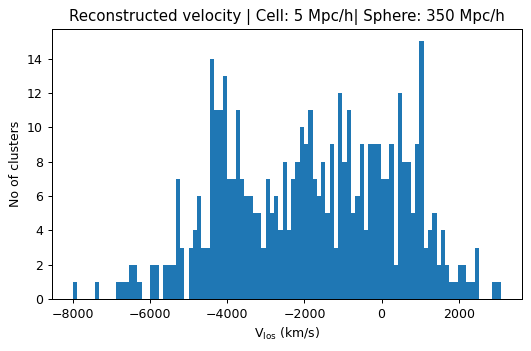

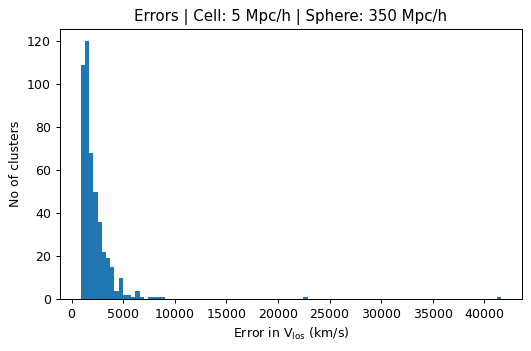

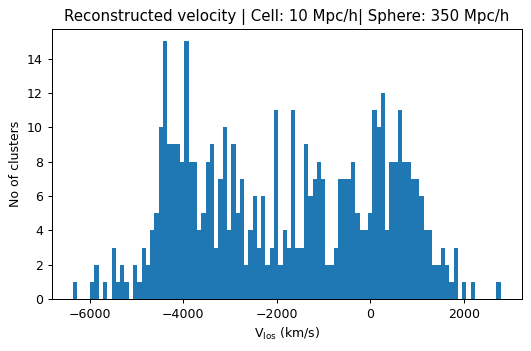

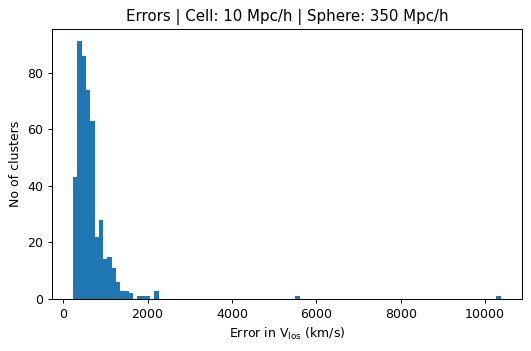

In [19]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [700000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_4_lt_7_{radius}_{cell_size}.csv')
        
# #         clear_output(wait=True)
        
                


        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

5000 200000
Time taken: 4.683188438415527


10000 200000
Time taken: 4.618069887161255


CPU times: user 3.13 s, sys: 3.05 s, total: 6.18 s
Wall time: 9.31 s


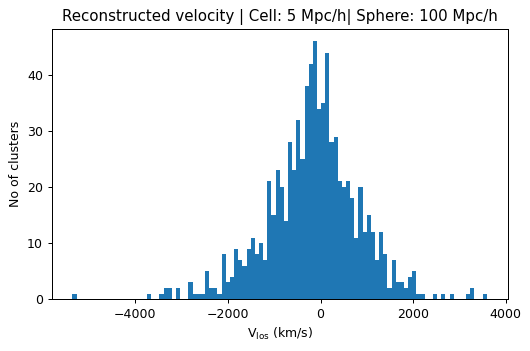

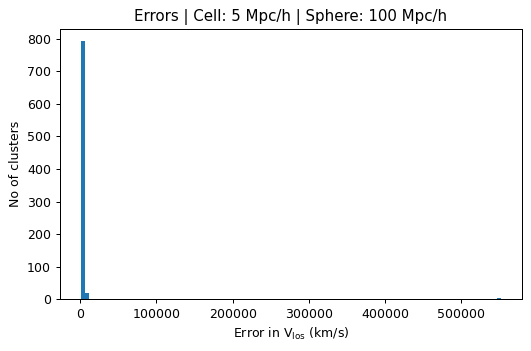

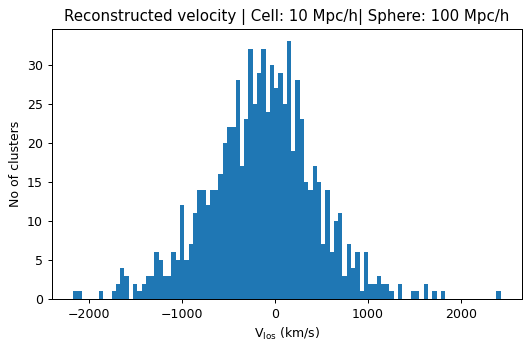

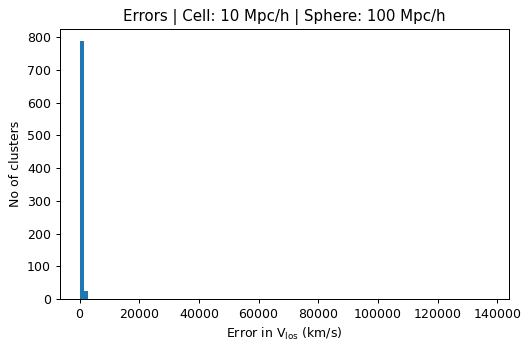

In [21]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [200000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_4_lt_7_{radius}_{cell_size}.csv')
        
# #         clear_output(wait=True)
        
                


        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

**1 Sep 2021**  
- With 100 Mpc, looks much better. Still, the maximum is not at zero but very close. Yes, it's a matter of sampling. So, calculate moments. We'll see they reduce with (increasing) the number of clusters. 

5000 500000
Time taken: 22.807048082351685


10000 500000
Time taken: 5.8557140827178955


CPU times: user 7.56 s, sys: 15 s, total: 22.5 s
Wall time: 28.7 s


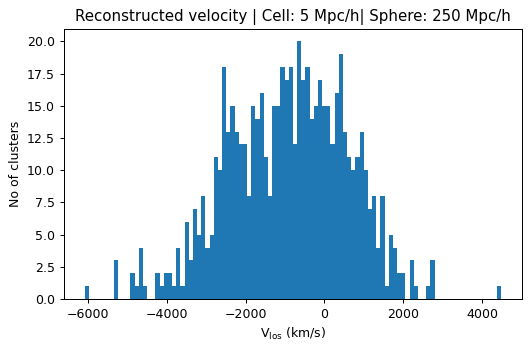

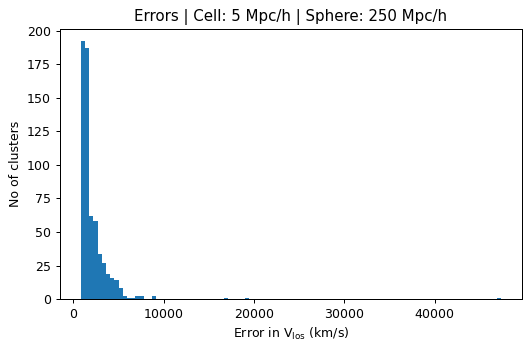

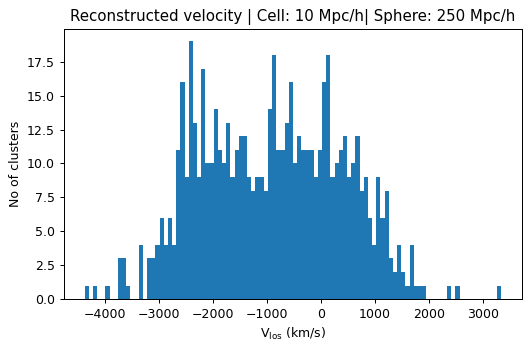

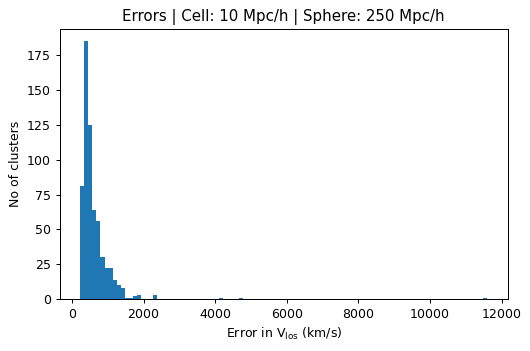

In [22]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [500000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
        
        df_clusters_est_err.to_csv(f'Data/with_vels/z_gt_4_lt_7_{radius}_{cell_size}.csv')
        

        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

**27 Aug 2021**  
A: Delta has an evolution. It could be less on one side of the box and more on the other. Not accouting for it can create a velocity dipole. Should be discussed with Emilio. Good to mention we can get a bias from this mistake. Though, people must have been taking care of it even if they don't mention it.  
**Task** There's no redshift evolution in 240 Mpc radius or diameter region. Worth trying to use only surrounding sphere to compute delta. Rerun one Magneticum result.  
**Task** Scatterplot to see how delta mean change (how it fluctuates) for the cluster catalog from the Magneticum.  
**Task** Check redshift intervel for Magneticum box. Must be .3 or .4. Have to plug in the distance formulat to get the redshift.  
**Task** Also calculate Poisson errors to see if it is matching the ones from Magneticum.  
**Task** Compare histograms of velocities from both Magneticum and SDSS for 5 Mpc, 10 Mpc and 20 Mpc.

**1 Sep 2021**  
A:
- The errors are smaller with 10 Mpc (go to basically 5000) than 5 Mpc (goes to 15000). This is because we have more galaxies in each cell for 10 Mpc.  

Getting true velocities

- To get true velocity, a thought was to do brute force samping from a true distribution to reconstructed distribution.
- We know how to go forward: we have a line with its own error: intercept error and slope error. So for each draw (of x which is v_true), we can always draw some random values of intercept and slope for each x axis value and on that add quadrature the scatter because scatter is also a Gaussion. And that will give you a y value. We can go from x to y. But how to go backwards from y to x?
- If this is a straight line, one can make the equation work both ways. But regression with a scatter is not interchangeable. You cannot flip because you use the error model along the Y, and scatter model in the y direction, not the X direction. Here, you fit the regression for the y values with respect to x, not the other way. Our regression basically only tells us how to go to Y value from x but not the other way around.
- If we want to map 10,000 distributions in X to see which one finally comes closest to Y that is not a very meaningful approach. It's not a well-defined. You never know if that is the solution right. You cannot just trial and error.. unless we have a theoretical model and we can define some chi square probability and do some MCMC kind of stuff. But we don't have any theoretical model for x velocities. 
- One easy way is to fit this regression in two parts. One is the bias part that is the deviation of the mean line from one is to one, that's the green line. Forget the errors for a moment. You get one unique definite X distribution whose errors are the same as the y distribution. 
- This error that we get is only from the error of galaxy count. There is an additional error because we don't have an infinite sample of galaxies cluster.. we have only a finite sample. So the determination of this green line also had an error and this error is encoded into the correlation coefficient. How much points scatter up and down from this. So (second part is) the error that is defined by the correlation coefficient, the scatter of the points. Then you can reverse map the Y distribution.
- ACT team assume there is a random component that does not match and reduce their Signal to Noise, obtained after stacking, by multiplying it with the correlation co-efficient. This just means increasing the noise or error. This method does not take into account any bias.
- Ideally, we wanted to do something more direct, use the full regression with its error to remap the reconstructed velocities to true velocity. If we figure out this method, it'd be great to compare it with the above easy method.
- We found two biases: 1. using a larger cell, 2. having mass bias, different mass bins have different slopes. So we must take into account these two biases. From 800 cluster, maybe we can make three mass bins. Then we have to apply three different regressions for the three mass bins.

Local density
- Mention in the write-ups we are using local field to calculate mean density.

**15 Sep 2021**  
B:
- Peculiar velocity and error magnitudes are acceptable numbers for these redshifts.
- Vel bias of clusters moving towards us could be due to cosmic variance, small volume, sampling limitation, selectio bias or more galaxy density at lower redshift than higher. Probably, cosmic variance plus this large statistical variance at each bin point. Or edge effects (cluster close to boundary).
- Direction bias understandable for 5 Mpc but not for 10 Mpc
- 10 Mpc (guess) vel hist better. Must be having Kurtosis close to zero. Vel dist not expected to be Gaussian.
- We can try 350 Mpc spheres. If we still see it, we can argue something is wrong with data. If it disappears, it means we need to correct for it when using smaller volumes.
- **Task** Let's quantify this bias. Compute the second order moment of the distribution. First moment is also biased because of our choice of cell sizes, we never get perfectly one is to one line.
- **Task** Check maximum (mode) of bins.
- **Task** Identify issue with high error clusters.

In [124]:
df_clusters_est_err.head()

,RADeg,decDeg,redshift,M500,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h],inside_clus,gals_beyond_250Mpc,...,z_comov[kpc/h],vx_est[km/s],vy_est[km/s],vz_est[km/s],vx_est_err[km/s],vy_est_err[km/s],vz_est_err[km/s],r_mag[kpc/h],v_los_est[km/s],v_los_est_err[km/s]
0,0.113536,-1.044805,0.438800,1.493793,2567.184731,2566.752876,5.086245,-46.810749,True,"[5764, 36714, 15413, 10670, 11580, 1016]",...,-46810.749408,2658.270950,1640.485495,1564.126982,3446.720076,3419.528896,3445.740049,2.567185e+06,2632.553271,3446.719644
1,0.179081,2.418384,0.422747,2.015433,2484.082955,2481.858364,7.757204,104.818959,True,"[6339, 53731, 15274, 13416, 9820, 1546]",...,104818.959114,1807.788970,-1537.105837,-868.459895,3315.938132,3352.342062,3301.365168,2.484083e+06,1764.724266,3315.912598
2,0.237445,-7.212459,0.551449,1.952599,3128.312832,3103.533166,12.861744,-392.756461,True,"[1123, 4129, 5769, 1023, 10234, 1]",...,-392756.460989,-2618.748616,-2712.579048,2200.269690,2966.832357,2981.074452,2922.573186,3.128313e+06,-2885.399351,2966.140084
3,1.531732,-2.524119,0.618213,2.649008,3443.245747,3438.675845,91.950645,-151.640319,True,"[355, 29426, 3698, 3020, 4050, 701]",...,-151640.319244,-18.075100,-2417.421282,-2220.125421,4775.756700,4750.407994,4770.591685,3.443246e+06,15.166699,4775.728659
4,1.642865,0.284479,0.682000,1.859439,3732.409014,3730.828805,107.004918,18.531709,True,"[67, 52165, 1522, 1486, 1215, 637]",...,18531.708797,-8892.119259,5560.333509,5239.950079,12254.372619,12277.799864,12271.852303,3.732409e+06,-8702.927864,12254.392324


In [129]:
df_clusters_est_err_sorted = df_clusters_est_err.sort_values(by='v_los_est_err[km/s]', ascending=False)
df_clusters_est_err_sorted

,RADeg,decDeg,redshift,M500,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h],inside_clus,gals_beyond_250Mpc,...,z_comov[kpc/h],vx_est[km/s],vy_est[km/s],vz_est[km/s],vx_est_err[km/s],vy_est_err[km/s],vz_est_err[km/s],r_mag[kpc/h],v_los_est[km/s],v_los_est_err[km/s]
153,38.223763,10.432503,0.448400,3.768657,2616.499670,2021.542996,1592.155534,473.788134,True,"[4042, 15846, 56, 18612, 274, 3866]",...,473788.133854,1992.586070,-1082.771330,-2111.984841,433995.586337,433995.093690,433995.683047,2.616500e+06,498.194098,433995.407091
167,40.725052,9.574959,0.438200,1.985134,2564.090940,1916.123154,1649.584097,426.505234,True,"[3885, 15179, 65, 19138, 14, 2999]",...,426505.233923,-175.102633,-188.916307,-2884.482854,88222.371329,88222.331599,88223.789953,2.564091e+06,-732.188765,88222.394136
710,317.954069,12.049954,0.428000,3.142264,2511.361529,1823.865060,-1644.864847,524.282944,True,"[4549, 17273, 15893, 8, 3, 1435]",...,524282.943860,1375.041655,484.651435,-2508.177975,27425.922407,27425.639704,27426.640860,2.511362e+06,157.567672,27425.832445
149,37.533386,7.630913,0.611600,2.937229,3412.617512,2682.234517,2060.635180,453.165461,True,"[359, 11469, 120, 27738, 16, 3834]",...,453165.461006,280.477252,-835.474960,-3117.145298,24749.344950,24749.556262,24750.789677,3.412618e+06,-697.964511,24749.447473
28,7.595814,9.012550,0.699912,2.508765,3811.609493,3731.518367,497.613398,597.091707,True,"[38, 44790, 583, 1655, 401, 1266]",...,597091.707070,-4904.214040,-7143.080089,6804.233620,23550.078306,23940.595043,23556.325572,3.811609e+06,-4667.819641,23556.941719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,190.700000,14.333333,0.491900,1.592576,2836.439488,-2700.363849,-510.239039,702.196679,True,"[32812, 3215, 17897, 9811, 9189, 4387]",...,702196.678669,-1676.154305,100.513230,157.174517,1788.772754,1780.337153,1778.693785,2.836439e+06,1616.571818,1787.884233
403,188.600000,17.279118,0.530897,1.624696,3028.767140,-2859.558802,-432.467608,899.625265,True,"[29621, 1869, 14980, 8214, 5423, 6586]",...,899625.264631,659.340326,-612.889423,136.171472,1789.087717,1772.999081,1772.312790,3.028767e+06,-494.545880,1787.287241
481,204.384218,3.765494,0.502100,1.668915,2887.182788,-2623.961768,-1189.410440,189.609849,True,"[25211, 2965, 22339, 6168, 11258, 1176]",...,189609.848986,-187.427391,-843.811440,-77.829952,1781.267594,1772.823601,1774.747538,2.887183e+06,512.847030,1779.809270
214,136.056637,14.988350,0.478179,2.051839,2767.687388,-1925.008771,1855.285485,715.786617,True,"[4963, 4839, 4059, 28642, 9738, 4013]",...,715786.616705,-1163.542942,-699.197073,138.267233,1767.950498,1751.855649,1743.796154,2.767687e+06,376.339477,1759.124580


In [205]:
min_gals_beyond_cube = []
for i in df_clusters_est_err_sorted['gals_beyond_250Mpc']:
    nums_int_list = []
    nums = i.split(',')
    for num in nums:
        num = num.lstrip('[').rstrip(']')
        nums_int_list.append(int(num))
    min_gals_beyond_cube.append(min(nums_int_list))
    
df_clusters_est_err_sorted['min_gals_beyond_cube'] = min_gals_beyond_cube
df_clusters_est_err_sorted['min_gals_beyond_cube']

153      56
167      14
710       3
149      16
28       38
       ... 
412    3215
403    1869
481    1176
214    4013
422    2513
Name: min_gals_beyond_cube, Length: 802, dtype: int64

Text(0, 0.5, 'Error in V$_{\\mathrm{los}}$')

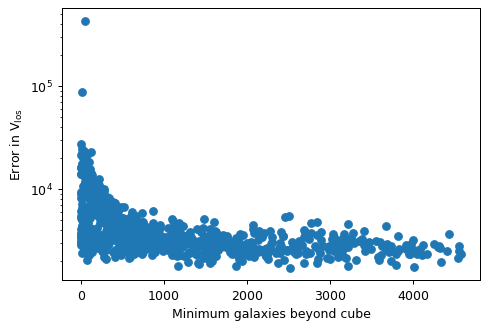

In [161]:
plt.figure(dpi = dpi)
plt.scatter(df_clusters_est_err_sorted['min_gals_beyond_cube'], df_clusters_est_err_sorted['v_los_est_err[km/s]'])
plt.yscale('log')
plt.xlabel('Minimum galaxies beyond cube')
plt.ylabel('Error in V$_{\mathrm{los}}$')

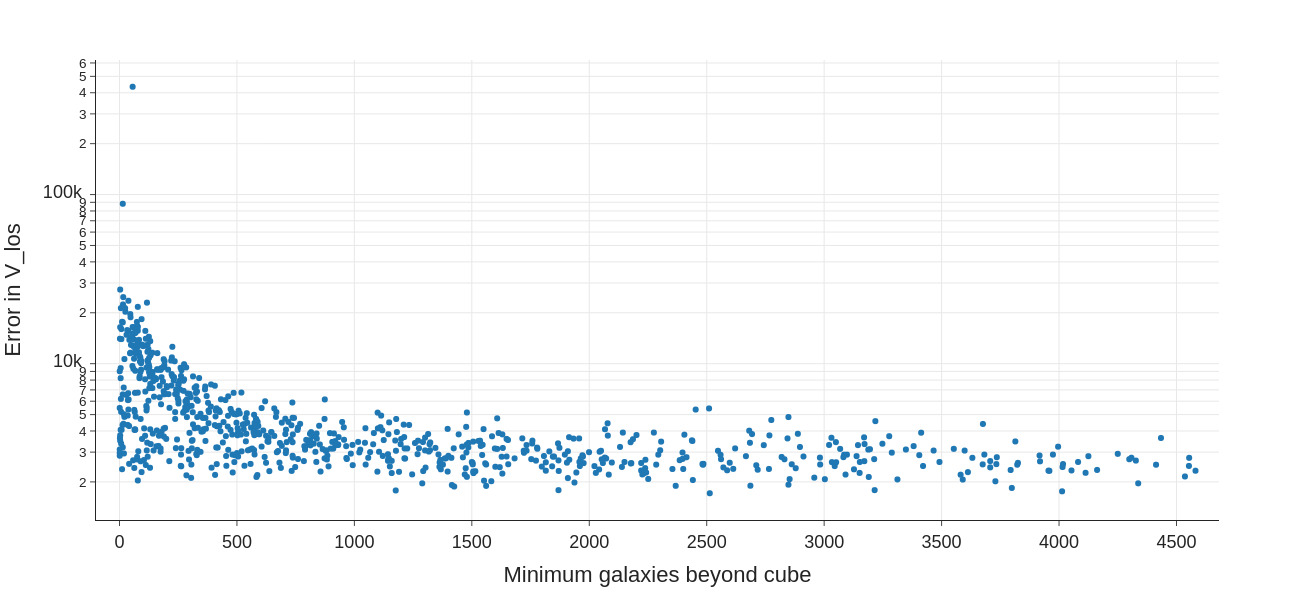

In [222]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est_err[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100]
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
    
fig.show()

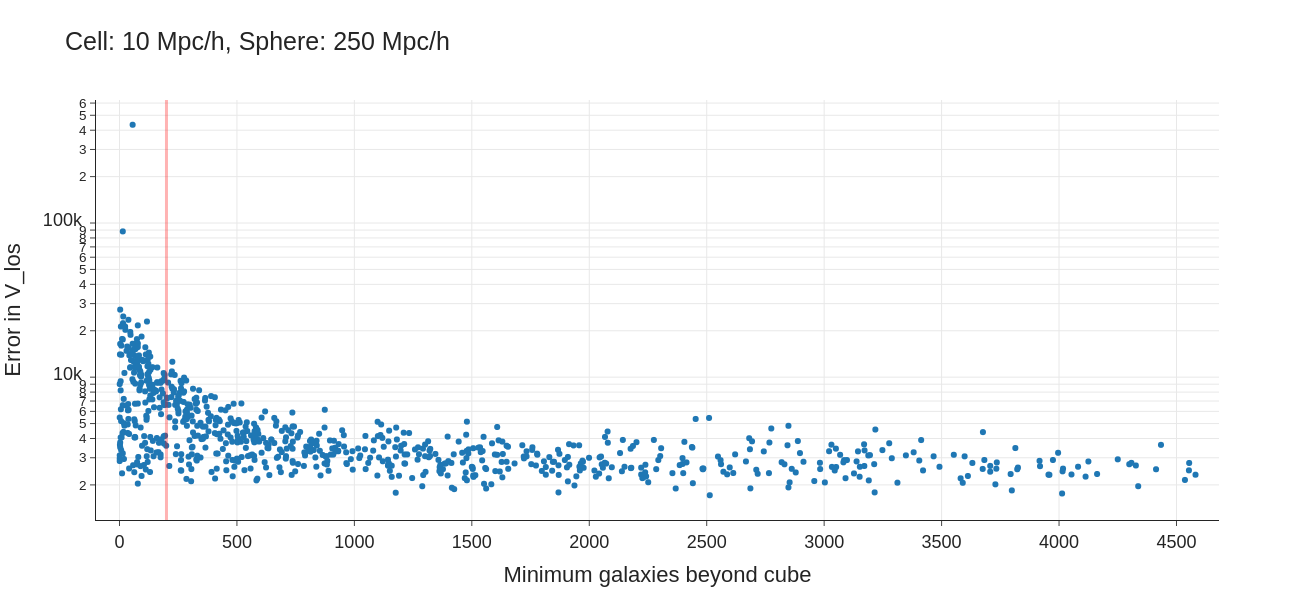

In [307]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est_err[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100],
                 title='Cell: 10 Mpc/h, Sphere: 250 Mpc/h', 
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
fig.add_vline(x=200, line_width=3, line_color = 'red')
# fig.title('Cell = 10000 Mpc/h')
    
fig.show()

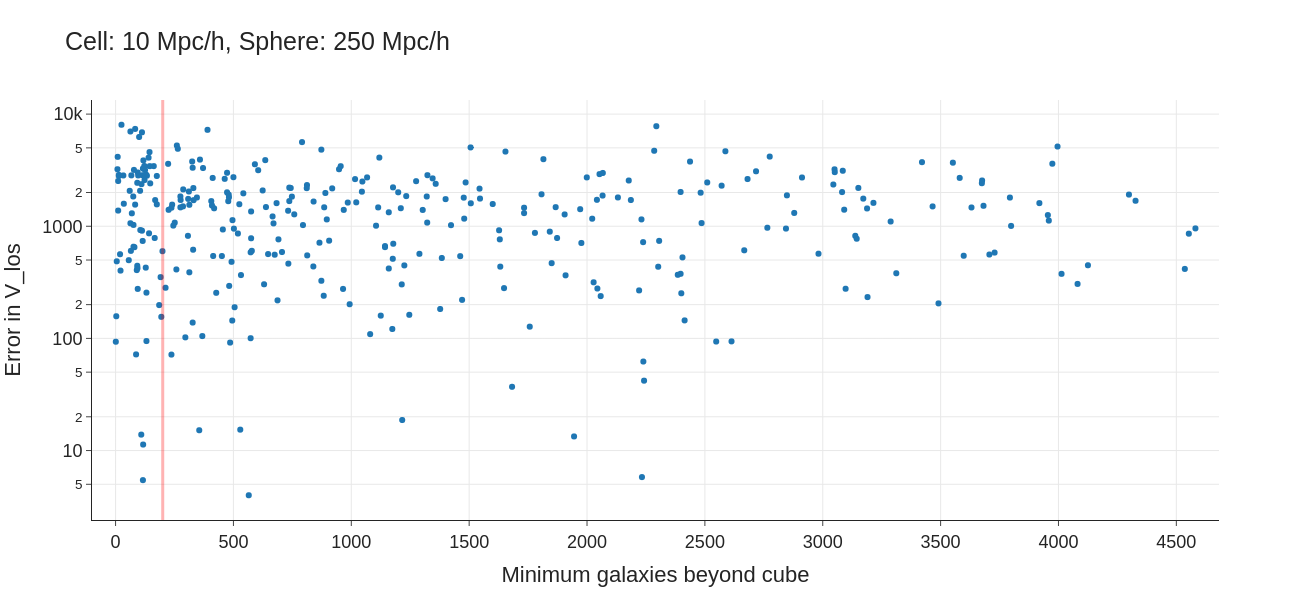

In [308]:
fig = px.scatter(x=df_clusters_est_err_sorted['min_gals_beyond_cube'], 
                 y=df_clusters_est_err_sorted['v_los_est[km/s]'],
                 labels={ "x": "Minimum galaxies beyond cube","y": "Error in V_los"},
                 log_y=True,
                 width=800,                  
                 height=600,
                 template="simple_white",   # 'ggplot2', 'seaborn', 'simple_white', 'plotly',
                                            # 'plotly_white', 'plotly_dark', 'presentation',
                                            # 'xgridoff', 'ygridoff', 'gridon', 'none'
                 range_x=[0-100, df_clusters_est_err_sorted['min_gals_beyond_cube'].max() + 100],
                 title='Cell: 10 Mpc/h, Sphere: 250 Mpc/h', 
                 
                )
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.update_layout(font=dict(size=18))
fig.add_vline(x=200, line_width=3, line_color = 'red')
# fig.title('Cell = 10000 Mpc/h')
    
fig.show()

In [23]:
skew_kurtosis = pd.DataFrame()


df_clus_100_5000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_100_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 100, 
                                      'Skewness' : df_clus_100_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_100_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_250_5000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_250_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 250, 
                                      'Skewness' : df_clus_250_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_250_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_350_5000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_350_5000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 350, 
                                      'Skewness' : df_clus_350_5000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_350_5000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

skew_kurtosis

,Sphere,Skewness,Kurtosis
0,100.0,-0.286733,1.772717
1,250.0,-0.205806,-0.008881
2,350.0,-0.126843,-0.807777


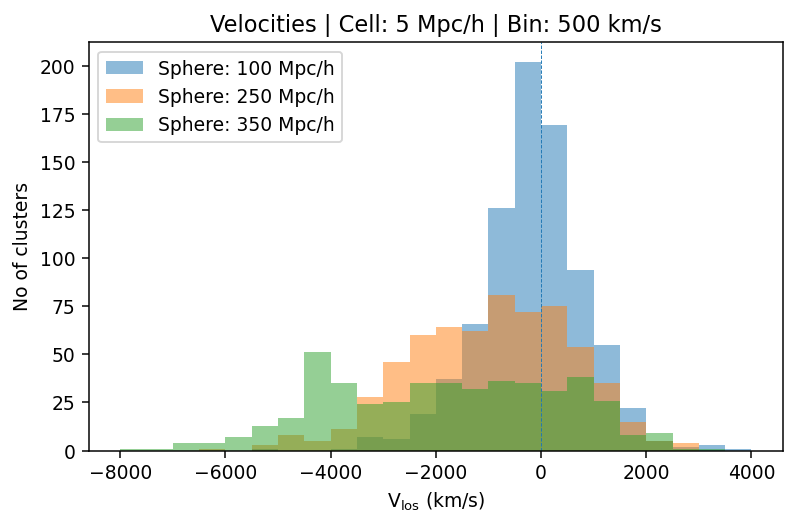

In [24]:
x_min = min(df_clus_100_5000['v_los_est[km/s]'].min(),
            df_clus_250_5000['v_los_est[km/s]'].min(),
            df_clus_350_5000['v_los_est[km/s]'].min())

x_max = max(df_clus_100_5000['v_los_est[km/s]'].max(),
            df_clus_250_5000['v_los_est[km/s]'].max(),
            df_clus_350_5000['v_los_est[km/s]'].max())

bin_size = 500
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_5000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_5000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_5000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)

plt.title(f'Velocities | Cell: 5 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
# plt.savefig('Plots/Practice_Talk/real_vels_5Mpc.pdf')

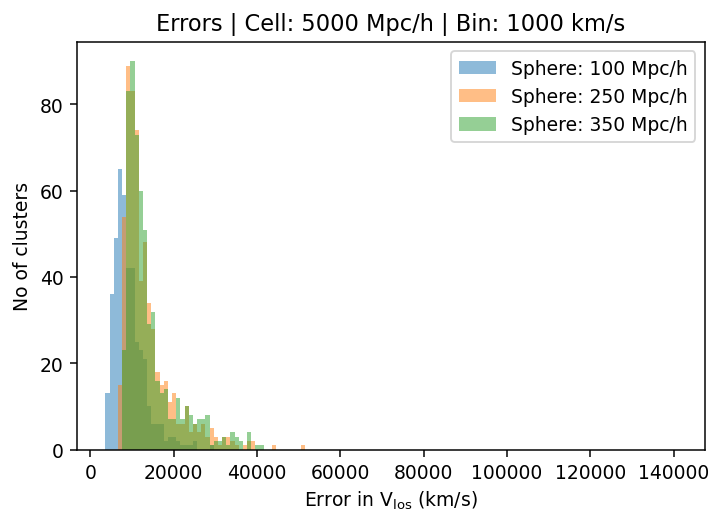

In [290]:
x_min = min(df_clus_100_5000['v_los_est_err[km/s]'].min(),
            df_clus_250_5000['v_los_est_err[km/s]'].min(),
            df_clus_350_5000['v_los_est_err[km/s]'].min())

x_max = max(df_clus_100_5000['v_los_est_err[km/s]'].max(),
            df_clus_250_5000['v_los_est_err[km/s]'].max(),
            df_clus_350_5000['v_los_est_err[km/s]'].max())

bin_size = 1000
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_5000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_5000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_5000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.title(f'Errors | Cell: 5000 Mpc/h | Bin: {bin_size} km/s');

In [25]:
skew_kurtosis = pd.DataFrame()


df_clus_100_10000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_100_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 100, 
                                      'Skewness' : df_clus_100_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_100_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_250_10000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_250_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 250, 
                                      'Skewness' : df_clus_250_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_250_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

df_clus_350_10000 = pd.read_csv('Data/with_vels/z_gt_4_lt_7_350_10000.csv')
skew_kurtosis = skew_kurtosis.append({'Sphere': 350, 
                                      'Skewness' : df_clus_350_10000['v_los_est[km/s]'].skew(),
                                      'Kurtosis' : df_clus_350_10000['v_los_est[km/s]'].kurtosis()}, 
                                     ignore_index=True)

skew_kurtosis

,Sphere,Skewness,Kurtosis
0,100.0,-0.010923,0.887286
1,250.0,0.039785,-0.681388
2,350.0,0.015931,-1.233024


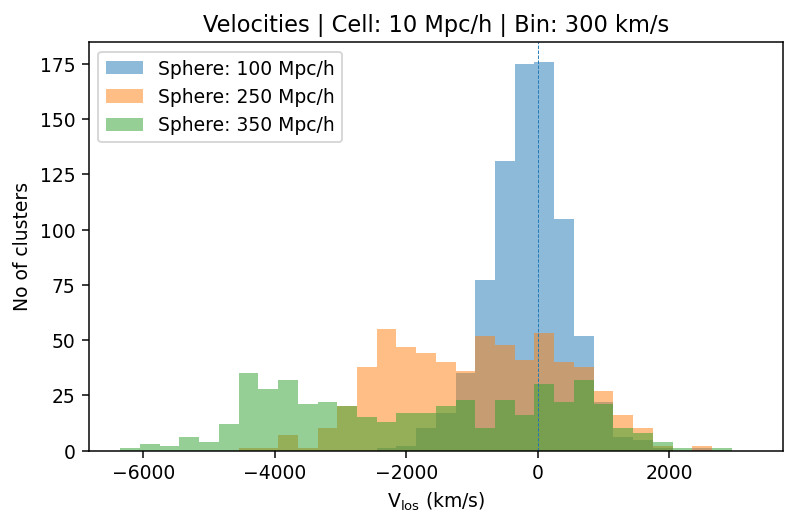

In [26]:
x_min = min(df_clus_100_10000['v_los_est[km/s]'].min(),
            df_clus_250_10000['v_los_est[km/s]'].min(),
            df_clus_350_10000['v_los_est[km/s]'].min())

x_max = max(df_clus_100_10000['v_los_est[km/s]'].max(),
            df_clus_250_10000['v_los_est[km/s]'].max(),
            df_clus_350_10000['v_los_est[km/s]'].max())

bin_size = 300
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_10000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_10000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_10000['v_los_est[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.axvline(x = 0, ls = 'dashed', lw = 0.5)
plt.title(f'Velocities | Cell: 10 Mpc/h | Bin: {bin_size} km/s');

plt.tight_layout()
plt.savefig('Plots/Practice_Talk/real_vels_10Mpc.pdf')

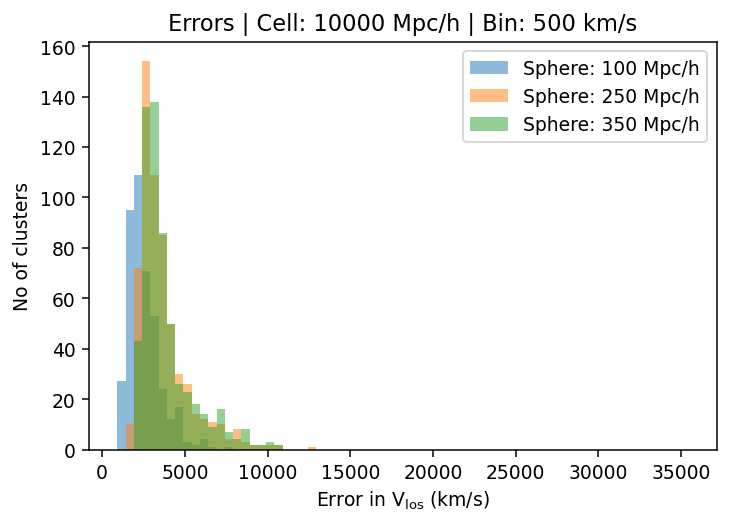

In [295]:
x_min = min(df_clus_100_10000['v_los_est_err[km/s]'].min(),
            df_clus_250_10000['v_los_est_err[km/s]'].min(),
            df_clus_350_10000['v_los_est_err[km/s]'].min())

x_max = max(df_clus_100_10000['v_los_est_err[km/s]'].max(),
            df_clus_250_10000['v_los_est_err[km/s]'].max(),
            df_clus_350_10000['v_los_est_err[km/s]'].max())

bin_size = 500
bins = np.arange(x_min, x_max, bin_size)

plt.figure(dpi = dpi*1.5)

plt.hist(df_clus_100_10000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 100 Mpc/h')
plt.hist(df_clus_250_10000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 250 Mpc/h')
plt.hist(df_clus_350_10000['v_los_est_err[km/s]'], alpha = 0.5, bins = bins,
         label = 'Sphere: 350 Mpc/h')
plt.legend()

plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
plt.ylabel('No of clusters')

plt.title(f'Errors | Cell: 10000 Mpc/h | Bin: {bin_size} km/s');